In [27]:
using Revise
using BilevelTrajOpt

using ForwardDiff
using DiffResults
using RigidBodyDynamics
using Plots
gr(size=(500,500), html_output_format=:png);

In [33]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)
body = findbody(mechanism, "ball")
basejoint = joint_to_parent(body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)
velocity_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)
μ = 0.68
motion_type = :xyz
point = Point3D(default_frame(findbody(mechanism, "floor")), [0.,0.,0.])
normal = FreeVector3D(default_frame(findbody(mechanism, "floor")), [0.,0.,1.])
hs = HalfSpace(point, normal)
floor = Obstacle(hs, μ, motion_type)
obstacles = [floor]
env = parse_contacts(mechanism, urdf, obstacles)
x0 = MechanismState(mechanism)
Δt = 0.005
sim_data = get_sim_data(x0,env,Δt,true);

In [75]:
N = 100
q0 = [1., 0., 0., 0., 0., 0., 0.]
v0 = [0., 0., 0., 5., 0., 0.]

u0 = zeros(sim_data.num_v)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
ctrl! = (u,t,x) -> u[:] .= 0.
traj = BilevelTrajOpt.simulate_snopt(x0,env,sim_data.Δt,N,ctrl!,implicit_contact=false)
# qnext = traj[1:sim_data.num_q,2]
# vnext = traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,2];

  0.000909 seconds (1.81 k allocations: 273.813 KiB)
  0.000831 seconds (1.81 k allocations: 273.813 KiB)
  0.000669 seconds (1.81 k allocations: 273.813 KiB)
  0.000668 seconds (1.81 k allocations: 273.813 KiB)
  0.000676 seconds (1.81 k allocations: 273.813 KiB)
  0.001269 seconds (1.81 k allocations: 273.813 KiB)
  0.001145 seconds (1.81 k allocations: 273.813 KiB)
  0.001147 seconds (1.81 k allocations: 273.813 KiB)
  0.001076 seconds (1.81 k allocations: 273.813 KiB)
  0.001029 seconds (1.81 k allocations: 273.813 KiB)
  0.000824 seconds (1.81 k allocations: 273.813 KiB)
Finished successfully: optimality conditions satisfied
  0.001628 seconds (1.81 k allocations: 273.813 KiB)
  0.001163 seconds (1.81 k allocations: 273.813 KiB)
  0.000906 seconds (1.81 k allocations: 273.813 KiB)
Finished successfully: optimality conditions satisfied
  0.001537 seconds (1.81 k allocations: 273.813 KiB)
  0.001226 seconds (1.81 k allocations: 273.813 KiB)
  0.000941 seconds (1.81 k allocations: 27

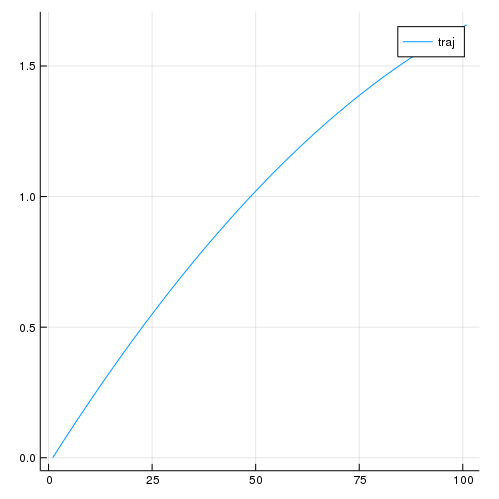

In [76]:
s = cumsum([Δt for i in 1:N]);
j = 5
plot(traj[j,:],label="traj")

In [ ]:
function friction_loss(μs)
    sim_data.μs[:] = [μs[1]]
    
    # for each q0, v0 etc in dataset
    loss = 0.
    for i = 1:N-1
        q0 = traj[1:sim_data.num_q,i]
        v0 = traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,i]
        qnext = traj[1:sim_data.num_q,i+1]
        vnext = traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,i+1]
        τ, x, d = solve_implicit_contact_τ(sim_data,q0,v0,u0,qnext,vnext,ip_method=false)
        loss += d'*d 
    end
    
    loss
end

μs0 = [1.,1.,1.]

fric_res = DiffResults.GradientResult(μs0)
function friction_fn(μs)
    ForwardDiff.gradient!(fric_res, friction_loss, μs)
    
#     J = friction_loss(μs)
    J = DiffResults.value(fric_res)
    gJ = DiffResults.gradient(fric_res)
    
    c = [] #vcat(0. .- μs, μs .- 1.)
    gc = [] #vcat(-ones(1),ones(1))
    
    fail = false
    
    J, c, gJ, gc, fail
#     J, c, fail
end

lb = zeros(length(μs0))
ub = ones(length(μs0))
options = Dict{String, Any}()
options["Derivative option"] = 0
options["Verify level"] = -1
options["Major optimality tolerance"] = 1e-6

@time μsopt, fopt, info = snopt(friction_fn, μs0, lb, ub, options)

display(info)
display(μsopt)

In [79]:
@time μsopt, fopt, info = snopt(friction_fn, μs0, lb, ub, options)

 25.196949 seconds (70.84 M allocations: 9.614 GiB, 26.52% gc time)


([0.68, 1.0, 1.0], 4.525709227182345e-15, "Finished successfully: optimality conditions satisfied")